<a href="https://colab.research.google.com/github/hemanthgupta29/hemanth_info5731_Spring2020/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
def LDA_MODEL(number_of_topics,tf,feature_names, no_top_words):
  number_of_topics = 10
  model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
  model.fit(tf)
  return display_topics(model,feature_names, no_top_words)
  pass

def display_topics(model, feature_names, no_top_words):
  topic_dict = {}
  for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
  return pd.DataFrame.from_dict(topic_dict)

In [29]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def LSA_MODEL(tf,vectorizer):
  svd_model = TruncatedSVD(n_components=1, algorithm ='randomized', n_iter=100, random_state=122)
  svd_model.fit(tf)
  terms = vectorizer.get_feature_names()
  df = pd.DataFrame()
  for i, comp in enumerate(svd_model.components_):
    term_comp = zip(terms,comp)
    sorted_terms = sorted(term_comp, key = lambda x:x[1], reverse = True)[:7]
    str1 = "Topic "+str(i)
    str2 = str1 + " weights"
    str1_list = list()
    str2_list = list()
    for j in sorted_terms:
      str1_list.append(j[0])
      str2_list.append(j[1])
    df[str1] = str1_list
    df[str2] = str2_list
  return df

In [1]:
from __future__ import print_function
import time

from six.moves import xrange
import numpy as np
from scipy.special import gammaln

class BaseTopicModel(object):
    def __init__(self, n_doc, n_voca, **kwargs):
        self.n_doc = n_doc
        self.n_voca = n_voca
        self.verbose = kwargs.pop('verbose', True)

class BaseGibbsParamTopicModel(BaseTopicModel):


    def __init__(self, n_doc, n_voca, n_topic, alpha, beta, **kwargs):
        super(BaseGibbsParamTopicModel, self).__init__(n_doc=n_doc, n_voca=n_voca, **kwargs)
        self.n_topic = n_topic
        self.TW = np.zeros([self.n_topic, self.n_voca])
        self.DT = np.zeros([self.n_doc, self.n_topic])
        self.sum_T = np.zeros(self.n_topic)

        self.alpha = alpha
        self.beta = beta

        self.topic_assignment = list()

        self.TW += self.beta
        self.sum_T += self.beta * self.n_voca
        self.DT += self.alpha

class HMM_LDA(BaseGibbsParamTopicModel):

    def __init__(self, n_docs, n_voca, n_topic, n_class, alpha=0.1, beta=0.01, gamma=0.1, eta=0.1, **kwargs):
        super(HMM_LDA, self).__init__(n_docs, n_voca, n_topic, alpha, beta, **kwargs)
        self.n_class = n_class

        self.gamma = gamma
        self.eta = eta

        self.CW = np.zeros([self.n_class, self.n_voca]) + self.gamma  # class x word
        self.sum_C = np.zeros([self.n_class]) + self.n_voca * self.gamma

        self.T = np.zeros([self.n_class + 2, self.n_class + 2]) + self.eta

        self.word_class = list()
        self.word_topic = list()

    def fit(self, docs, max_iter=100):
        self.random_init(docs)
        self.gibbs_sampling(docs, max_iter)

    # randomly initialize 
    def random_init(self, docs):

        for di in xrange(self.n_doc):
            doc = docs[di]
            num_sentence = len(doc)

            doc_class = list()
            doc_topic = list()

            for si in xrange(num_sentence):
                sentence_class = list()
                sentence_topic = list()

                sentence = doc[si]
                len_sentence = len(sentence)

                for wi in xrange(len_sentence):
                    word = sentence[wi]
                    c = np.random.randint(self.n_class)

                    sentence_class.append(c)
                    self.CW[c, word] += 1
                    self.sum_C[c] += 1
                    if wi == 0:  # if the first word
                        self.T[self.n_class, c] += 1
                    else:
                        self.T[sentence_class[wi - 1], c] += 1

                    if wi == len_sentence - 1:  # the last word
                        self.T[c, self.n_class + 1] += 1

                    k = np.random.randint(self.n_topic)
                    sentence_topic.append(k)
                    self.DT[di, k] += 1
                    if c == 0:
                        self.TW[k, word] += 1
                        self.sum_T[k] += 1

                doc_class.append(sentence_class)
                doc_topic.append(sentence_topic)

            self.word_class.append(doc_class)
            self.word_topic.append(doc_topic)

    def gibbs_sampling(self, docs, max_iter):

        for iter in xrange(max_iter):
            tic = time.time()
            for di, doc in enumerate(docs):
                doc_topic = self.word_topic[di]
                doc_class = self.word_class[di]

                for si, sentence in enumerate(doc):
                    len_sentence = len(sentence)

                    sentence_topic = doc_topic[si]
                    sentence_class = doc_class[si]

                    for wi, word in enumerate(sentence):

                        if wi == 0:
                            prev_c = self.n_class
                        else:
                            prev_c = sentence_class[wi - 1]

                        if wi == len_sentence - 1:
                            next_c = self.n_class + 1
                        else:
                            next_c = sentence_class[wi + 1]

                        old_c = sentence_class[wi]
                        old_t = sentence_topic[wi]

                        # remove previous state
                        self.CW[old_c, word] -= 1
                        self.sum_C[old_c] -= 1
                        self.T[prev_c, old_c] -= 1
                        self.T[old_c, next_c] -= 1

                        # sample class
                        prob = (self.T[prev_c, :self.n_class] / self.T[prev_c].sum()) \
                                * (self.T[:self.n_class, next_c] / np.sum(self.T[:self.n_class], 1))
                        prob[0] *= (self.TW[old_t, word] / self.sum_T[old_t])
                        prob[1:] *= self.CW[1:, word] / self.sum_C[1:]

                        new_c = np.random.multinomial(1, prob).argmax()

                        sentence_class[wi] = new_c
                        self.CW[new_c, word] += 1
                        self.sum_C[new_c] += 1
                        self.T[prev_c, new_c] += 1
                        self.T[new_c, next_c] += 1

                        # remove previous topic state
                        self.DT[di, old_t] -= 1
                        if old_c == 0:
                            self.TW[old_t, word] -= 1
                            self.sum_T[old_t] -= 1

                        # sample topic
                        prob = self.DT[di].copy()
                        if new_c == 0:
                            prob *= self.TW[:, word] / self.sum_T
                        prob /= np.sum(prob)

                        new_topic = np.random.multinomial(1, prob).argmax()
                        self.DT[di, new_topic] += 1
                        if new_c == 0:
                            self.TW[new_topic, word] += 1
                            self.sum_T[new_topic] += 1
                        sentence_topic[wi] = new_topic

            if self.verbose:
                ll = self.log_likelihood()
                logger.info('[ITER] %d,\telapsed time: %.2f\tlog-likelihood:%.2f', iter, time.time() - tic, ll)

    def log_likelihood(self):

        ll = self.n_doc * gammaln(self.alpha * self.n_topic)
        ll -= self.n_doc * self.n_topic * gammaln(self.alpha)
        ll += self.n_topic * gammaln(self.beta * self.n_voca)
        ll -= self.n_topic * self.n_voca * gammaln(self.beta)

        for di in xrange(self.n_doc):
            ll += gammaln(self.DT[di]).sum() - gammaln(self.DT[di].sum())
        for ki in xrange(self.n_topic):
            ll += gammaln(self.TW[ki]).sum() - gammaln(self.sum_T[ki])

        if self.n_class != 1:
            ll += (self.n_class - 1) * gammaln(self.gamma * (self.n_class - 1))
            ll -= (self.n_class - 1) * self.n_voca * gammaln(self.gamma)
            ll += (self.n_class + 2) * gammaln(self.eta * (self.n_class + 2))
            ll -= (self.n_class + 2) * (self.n_class + 2) * gammaln(self.eta)

            for ci in xrange(1, self.n_class):
                ll += gammaln(self.CW[ci]).sum() - gammaln(self.sum_C[ci])
            for ci in xrange(self.n_class + 2):
                ll += gammaln(self.T[ci]).sum() - gammaln(self.T[ci].sum())

        return ll

In [17]:
from __future__ import print_function

import numpy as np
from scipy.special import gammaln
from scipy.stats import norm
from numpy.linalg import solve
from six.moves import xrange

import numpy as np


import numpy as np

from six.moves import xrange


def sampling_from_dist(prob):
    """ Sample index from a list of unnormalised probability distribution
        same as np.random.multinomial(1, prob/np.sum(prob)).argmax()
    Parameters
    ----------
    prob: ndarray
        array of unnormalised probability distribution
    Returns
    -------
    new_topic: return a sampled index
    """
    thr = prob.sum() * np.random.rand()
    new_topic = 0
    tmp = prob[new_topic]
    while tmp < thr:
        new_topic += 1
        tmp += prob[new_topic]
    return new_topic


def sampling_from_dict(prob):
    """ sample key from dictionary `prob` where values are unnormalised probability distribution
    Parameters
    ----------
    prob: dict
        key = topic
        value = unnormalised probability of the topic
    Returns
    -------
    key: int
        sampled key
    """
    prob_sum = sum(prob.values())

    thr = prob_sum * np.random.rand()
    tmp = 0
    for key, p in prob.items():
        tmp += p
        if tmp < thr:
            new_topic = key
    return new_topic


def isfloat(value):
    """
    Check the value is convertable to float value
    """
    try:
        float(value)
        return True
    except ValueError:
        return False


def read_voca(path):
    """
    open file from path and read each line to return the word list
    """
    with open(path, 'r') as f:
        return [word.strip() for word in f.readlines()]


def word_cnt_to_bow_list(word_ids, word_cnt):
    corpus_list = list()
    for di in xrange(len(word_ids)):
        doc_list = list()
        for wi in xrange(len(word_ids[di])):
            word = word_ids[di][wi]
            for c in xrange(word_cnt[di][wi]):
                doc_list.append(word)
        corpus_list.append(doc_list)
    return corpus_list


def log_normalize(log_prob_vector):
    """
    returns a probability vector of log probability vector
    """
    max_v = log_prob_vector.max()
    log_prob_vector += max_v
    log_prob_vector = np.exp(log_prob_vector)
    log_prob_vector /= log_prob_vector.sum()
    return log_prob_vector


def convert_cnt_to_list(word_ids, word_cnt):
    corpus = list()

    for di in xrange(len(word_ids)):
        doc = list()
        doc_ids = word_ids[di]
        doc_cnt = word_cnt[di]
        for wi in xrange(len(doc_ids)):
            word_id = doc_ids[wi]
            for si in xrange(doc_cnt[wi]):
                doc.append(word_id)
        corpus.append(doc)
    return corpus


def write_top_words(topic_word_matrix, vocab, filepath, n_words=20, delimiter=',', newline='\n'):
    with open(filepath, 'w') as f:
        for ti in xrange(topic_word_matrix.shape[0]):
            top_words = vocab[topic_word_matrix[ti, :].argsort()[::-1][:n_words]]
            f.write('%d' % (ti))
            for word in top_words:
                f.write(delimiter + word)
            f.write(newline)


def get_top_words(topic_word_matrix, vocab, topic, n_words=20):
    if not isinstance(vocab, np.ndarray):
        vocab = np.array(vocab)
    top_words = vocab[topic_word_matrix[topic].argsort()[::-1][:n_words]]
    return top_words


class BaseTopicModel(object):
    """
    Attributes
    ----------
    n_doc: int
        the number of total documents in the corpus
    n_voca: int
        the vocabulary size of the corpus
    verbose: boolean
        if True, print each iteration step while inference.
    """
    def __init__(self, n_doc, n_voca, **kwargs):
        self.n_doc = n_doc
        self.n_voca = n_voca
        self.verbose = kwargs.pop('verbose', True)


class BaseGibbsParamTopicModel(BaseTopicModel):
    """ Base class of parametric topic models with Gibbs sampling inference
    Attributes
    ----------
    n_topic: int
        a number of topics to be inferred through the Gibbs sampling
    TW: ndarray, shape (n_voca, n_topic)
        word-topic matrix, keeps the number of assigned word tokens for each word-topic pair
    DT: ndarray, shape (n_doc, n_topic)
        document-topic matrix, keeps the number of assigned word tokens for each document-topic pair
    sum_T: ndarray, shape (n_topic)
        number of word tokens assigned for each topic
    alpha: float
        symmetric parameter of Dirichlet prior for document-topic distribution
    beta: float
        symmetric parameter of Dirichlet prior for topic-word distribution
    """

    def __init__(self, n_doc, n_voca, n_topic, alpha, beta, **kwargs):
        super(BaseGibbsParamTopicModel, self).__init__(n_doc=n_doc, n_voca=n_voca, **kwargs)
        self.n_topic = n_topic
        self.TW = np.zeros([self.n_topic, self.n_voca])
        self.DT = np.zeros([self.n_doc, self.n_topic])
        self.sum_T = np.zeros(self.n_topic)

        self.alpha = alpha
        self.beta = beta

        self.topic_assignment = list()

        self.TW += self.beta
        self.sum_T += self.beta * self.n_voca
        self.DT += self.alpha

class SupervisedLDA(BaseGibbsParamTopicModel):
    """ Supervised LDA with Gaussian response variables
    Attributes
    ----------
    eta: ndarray, shape (n_topic)
        coefficient parameter of Gaussian distribution where the mean is np.dot(z_bar.T, eta)
    sigma: float
        variance parameter of Gaussian output variables
    """

    def __init__(self, n_doc, n_voca, n_topic, alpha=0.1, beta=0.01, sigma=1., **kwargs):
        super(SupervisedLDA, self).__init__(n_doc=n_doc, n_voca=n_voca, n_topic=n_topic, alpha=alpha, beta=beta,
                                                 **kwargs)
        self.eta = np.random.normal(scale=5, size=self.n_topic)
        self.sigma = sigma

    def random_init(self, docs):
        """
        Random initialization of topics
        Parameters
        ----------
        docs:
        """
        for di in xrange(len(docs)):
            doc = docs[di]
            topics = np.random.randint(self.n_topic, size=len(doc))
            self.topic_assignment.append(topics)

            for wi in xrange(len(doc)):
                topic = topics[wi]
                word = doc[wi]
                self.TW[topic, word] += 1
                self.sum_T[topic] += 1
                self.DT[di, topic] += 1

    def fit(self, docs, responses, max_iter=100):
        """ Stochastic Expectation Maximisation algorithm
        """
        self.random_init(docs)
        for iteration in xrange(max_iter):

            for di in xrange(len(docs)):
                doc = docs[di]
                for wi in xrange(len(doc)):
                    word = doc[wi]
                    old_topic = self.topic_assignment[di][wi]

                    self.TW[old_topic, word] -= 1
                    self.sum_T[old_topic] -= 1
                    self.DT[di, old_topic] -= 1

                    z_bar = np.zeros([self.n_topic, self.n_topic]) + self.DT[di, :] + np.identity(self.n_topic)
                    # this seems more straightforward than z_bar/z_bar.sum(1)
                    z_bar /= self.DT[di, :].sum() + 1

                    # update
                    prob = (self.TW[:, word]) / (self.sum_T) * (self.DT[di, :]) * np.exp(
                        np.negative((responses[di] - np.dot(z_bar, self.eta)) ** 2) / 2 / self.sigma)

                    new_topic = sampling_from_dist(prob)

                    self.topic_assignment[di][wi] = new_topic
                    self.TW[new_topic, word] += 1
                    self.sum_T[new_topic] += 1
                    self.DT[di, new_topic] += 1

            # estimate parameters
            z_bar = self.DT / self.DT.sum(1)[:, np.newaxis]  # DxK
            self.eta = solve(np.dot(z_bar.T, z_bar), np.dot(z_bar.T, responses))

            # compute mean absolute error
            mae = np.mean(np.abs(responses - np.dot(z_bar, self.eta)))
            #if self.verbose:
             #   logger.info('[ITER] %d,\tMAE:%.2f,\tlog_likelihood:%.2f', iteration, mae,
              #              self.log_likelihood(docs, responses))

    def sample_heldout_doc(self, max_iter, heldout_docs):
        h_doc_topics = list()
        h_doc_topic_sum = np.zeros([len(heldout_docs), self.n_topic]) + self.alpha

        # random init
        for di in xrange(len(heldout_docs)):
            doc = heldout_docs[di]
            topics = np.random.randint(self.n_topic, size=len(doc))
            h_doc_topics.append(topics)

            for wi in xrange(len(doc)):
                topic = topics[wi]
                h_doc_topic_sum[di, topic] += 1

        for iter in xrange(max_iter):
            for di in xrange(len(heldout_docs)):
                doc = heldout_docs[di]
                for wi in xrange(len(doc)):
                    word = doc[wi]
                    old_topic = h_doc_topics[di][wi]

                    h_doc_topic_sum[di, old_topic] -= 1

                    # update
                    prob = (self.TW[:, word] / self.sum_T) * (self.DT[di, :])

                    new_topic = sampling_from_dist(prob)

                    h_doc_topics[di][wi] = new_topic
                    h_doc_topic_sum[di, new_topic] += 1

        return h_doc_topic_sum

    def log_likelihood(self, docs, responses):
        """
        likelihood function
        """
        ll = 0

        ll += len(docs) * gammaln(self.alpha * self.n_topic)
        ll -= len(docs) * self.n_topic * gammaln(self.alpha)
        ll += self.n_topic * gammaln(self.beta * self.n_voca)
        ll -= self.n_topic * self.n_voca * gammaln(self.beta)

        for di in xrange(self.n_doc):
            ll += gammaln(self.DT[di, :]).sum() - gammaln(self.DT[di, :].sum())
            z_bar = self.DT[di] / np.sum(self.DT[di])
            mean = np.dot(z_bar, self.eta)
            ll += norm.logpdf(responses[di], mean, np.sqrt(self.sigma))
        for ki in xrange(self.n_topic):
            ll += gammaln(self.TW[ki, :]).sum() - gammaln(self.TW[ki, :].sum())

        return ll

In [35]:
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM
import numpy as np
def BITERM_MODEL(tf, vectorizer):
  vocab = np.array(vectorizer.get_feature_names())
  biterms = vec_to_biterms(tf)
  btm = oBTM(num_topics=1, V= vocab)
  topics = btm.fit_transform(biterms, iterations=100)
  return topics
  pass

In [5]:
import pandas as pd
df=pd.read_csv('category.csv')
input_df= df.head(5000)
df

,Category (incl. context and answer),Description
0,Document Name,The name of the contract
1,Parties,The two or more parties who signed the contract
2,Agreement Date,The date of the contract
3,Effective Date,The date when the contract is effective
4,Expiration Date,On what date will the contract's initial term ...
5,Renewal Term,What is the renewal term after the initial ter...
6,Notice to Terminate Renewal,What is the notice period required to terminat...
7,Governing Law,Which state/country's law governs the interpre...
8,Most Favored Nation,Is there a clause that if a third party gets b...
9,Non-Compete,Is there a restriction on the ability of a par...


In [6]:
input_df.shape

(40, 2)

In [7]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Category (incl. context and answer)  40 non-null     object
 1   Description                          40 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes


In [8]:
print(input_df.isnull().sum())
# Dropping the null values
input_df=input_df.dropna()

Category (incl. context and answer)    0
Description                            0
dtype: int64


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words=stopwords.words("english")
# cleaning the text data
input_df['cleaned_data'] = input_df['Description'].str.replace(r"\W", " ").str.strip()# 1.To remove special characters and punctuations
input_df['cleaned_data'] = input_df['cleaned_data'].str.replace(r'\d+',"") #2.To remove Numbers
input_df['cleaned_data'] = input_df['cleaned_data'].apply(lambda x: " ".join(x.lower() for x in x.split())) #convert the whole text into lower case
input_df['cleaned_data'] = input_df['cleaned_data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) #remove all stop words
#input_df['cleaned text review'] # dataframe column that would be used for further process
input_df

#data cleaning for Labels
input_df['labels'] = input_df['Category (incl. context and answer)'].str.replace(r"\W", " ").str.strip()# 1.To remove special characters and punctuations
input_df['labels'] = input_df['labels'].apply(lambda x: " ".join(x.lower() for x in x.split())) #convert the whole text into lower case
input_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Category (incl. context and answer),Description,cleaned_data,labels
0,Document Name,The name of the contract,name contract,document name
1,Parties,The two or more parties who signed the contract,two parties signed contract,parties
2,Agreement Date,The date of the contract,date contract,agreement date
3,Effective Date,The date when the contract is effective,date contract effective,effective date
4,Expiration Date,On what date will the contract's initial term ...,date contract initial term expire,expiration date
5,Renewal Term,What is the renewal term after the initial ter...,renewal term initial term expires includes aut...,renewal term
6,Notice to Terminate Renewal,What is the notice period required to terminat...,notice period required terminate renewal,notice to terminate renewal
7,Governing Law,Which state/country's law governs the interpre...,state country law governs interpretation contract,governing law
8,Most Favored Nation,Is there a clause that if a third party gets b...,clause third party gets better terms licensing...,most favored nation
9,Non-Compete,Is there a restriction on the ability of a par...,restriction ability party compete counterparty...,non compete


In [8]:

from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(input_df['cleaned_data']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [9]:

import sys
sys.path.insert(1,'/content/')

In [18]:
#import AlgorithmLDA as lda_ul
result = LDA_MODEL(10,tf,tf_feature_names,10)
result

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,contract,0.1,contract,17.1,contract,0.1,contract,0.1,contract,0.1,contract,0.1,party,18.6,contract,10.1,party,7.1,contract,0.1
1,party,0.1,party,0.1,party,0.1,party,0.1,party,0.1,party,0.1,contract,0.1,party,5.6,contract,5.1,party,0.1


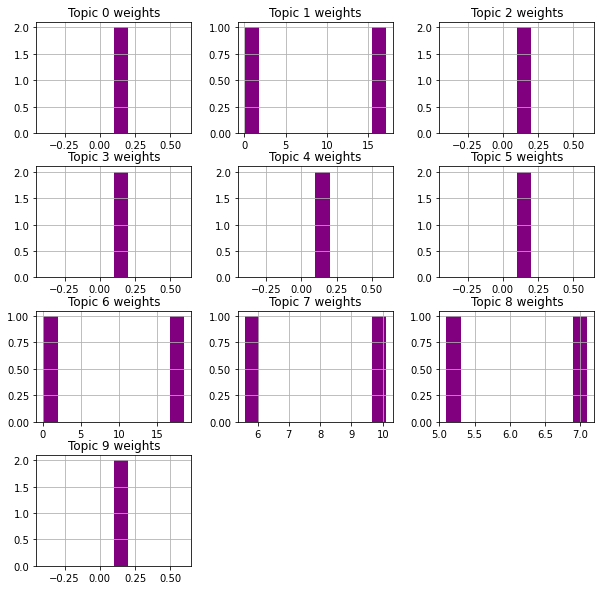

In [19]:

import matplotlib.pyplot as plt
columns_list = ["Topic "+str(i)+" weights" for i in range(0,10)]
for i in columns_list:
  result[i] = pd.to_numeric(result[i])
result.hist(figsize=(10,10),color = 'Purple')
plt.show(block=False)

In [21]:

result.plot(kind='density', subplots=True,layout = (2,2),sharex=False, legend=True, fontsize=1,figsize=(15,15))
plt.show(block=False)

ValueError: ignored

<Figure size 1080x1080 with 0 Axes>

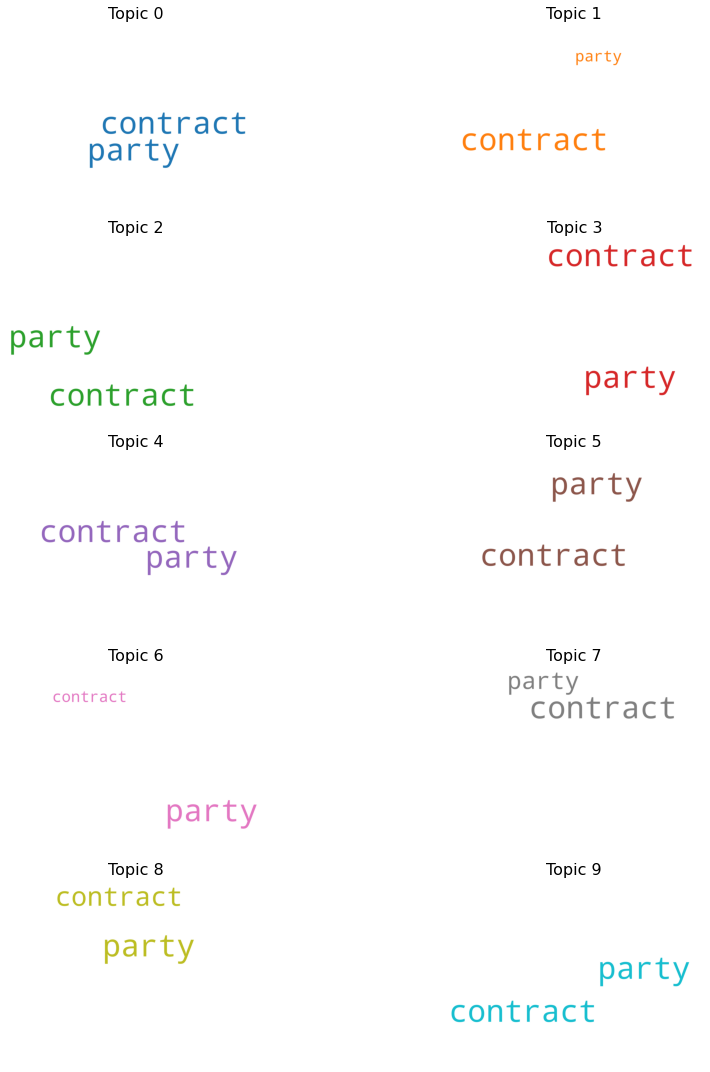

In [22]:
# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
my_stopwords = nltk.corpus.stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=my_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

columns_list = ["Topic "+str(i)+" words" for i in range(0,10)]
topics = list()

for i in columns_list:
  topics.append(result[i].values)

frequencies = list()
columns_list = ["Topic "+str(i)+" weights" for i in range(0,10)]

for i in columns_list:
  frequencies.append(result[i].values)


fig, axes = plt.subplots(5,2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    size_of_array = len(topics[i])
    topic_words = dict()
    for j in range(size_of_array):
      topic_words[topics[i][j]] = frequencies[i][j]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:

#import AlgorithmLSA as lsa
lsa_result=LSA_MODEL(tf,vectorizer)
lsa_result

,Topic 0,Topic 0 weights
0,contract,0.714433
1,party,0.699704


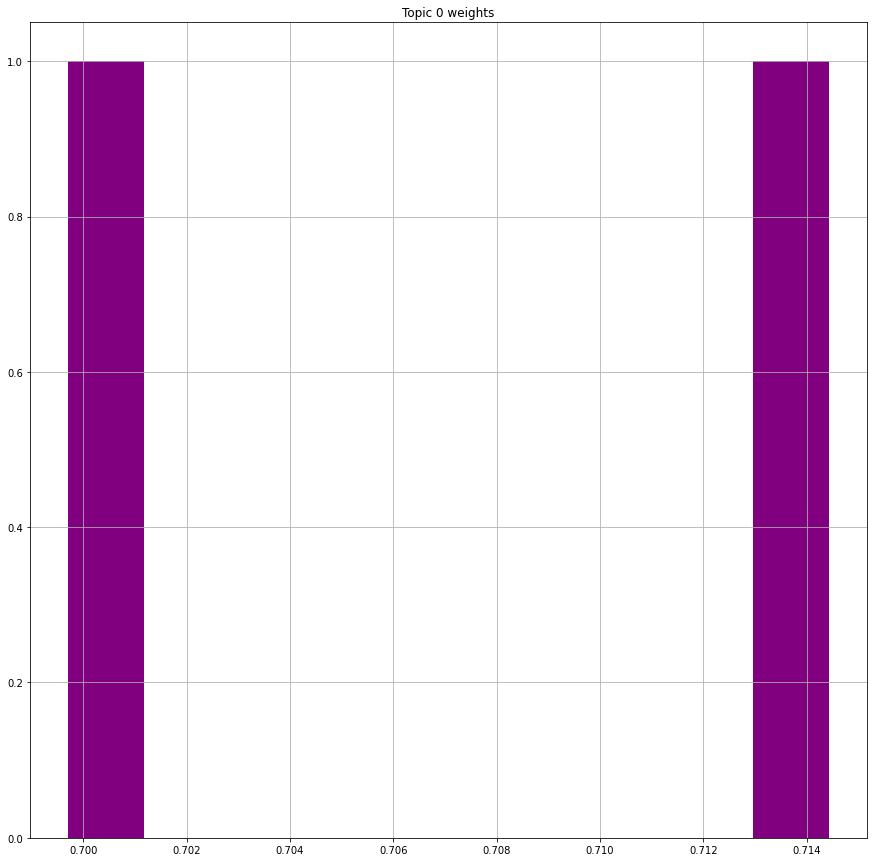

In [34]:

columns_list = ["Topic "+str(i)+" weights" for i in range(0,1)]
for i in columns_list:
  lsa_result[i] = pd.to_numeric(lsa_result[i])
lsa_result.hist(figsize=(15,15),color = 'purple')
plt.show(block=False)

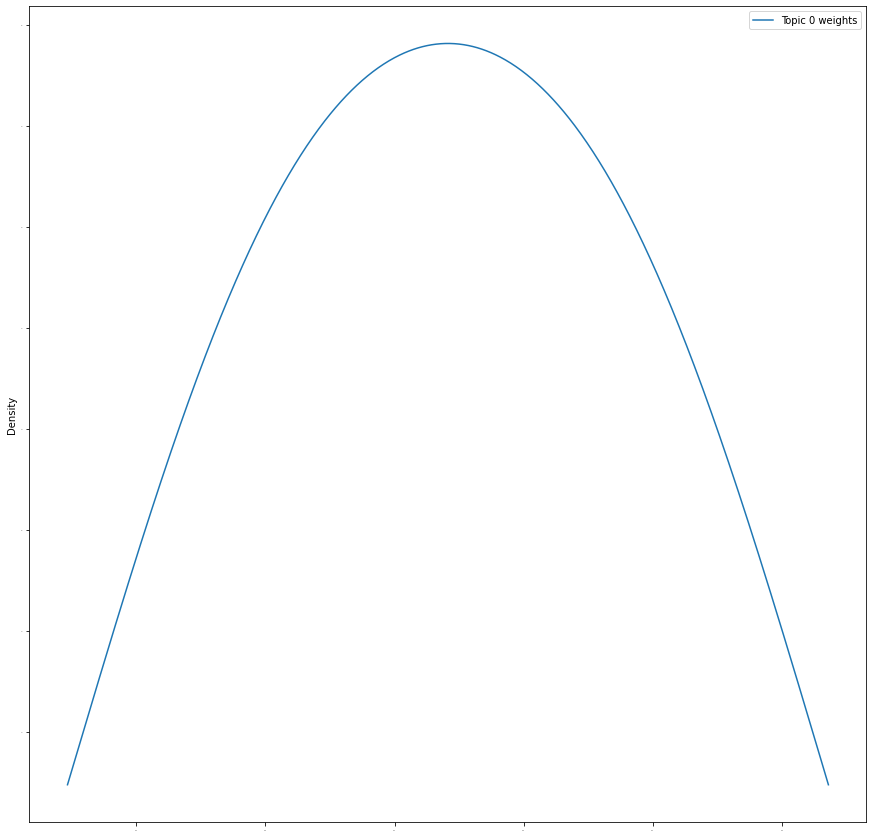

In [35]:
lsa_result.plot(kind='density', subplots=True,layout = (1,1),sharex=False, legend=True, fontsize=1,figsize=(15,15))
plt.show(block=False)

IndexError: ignored

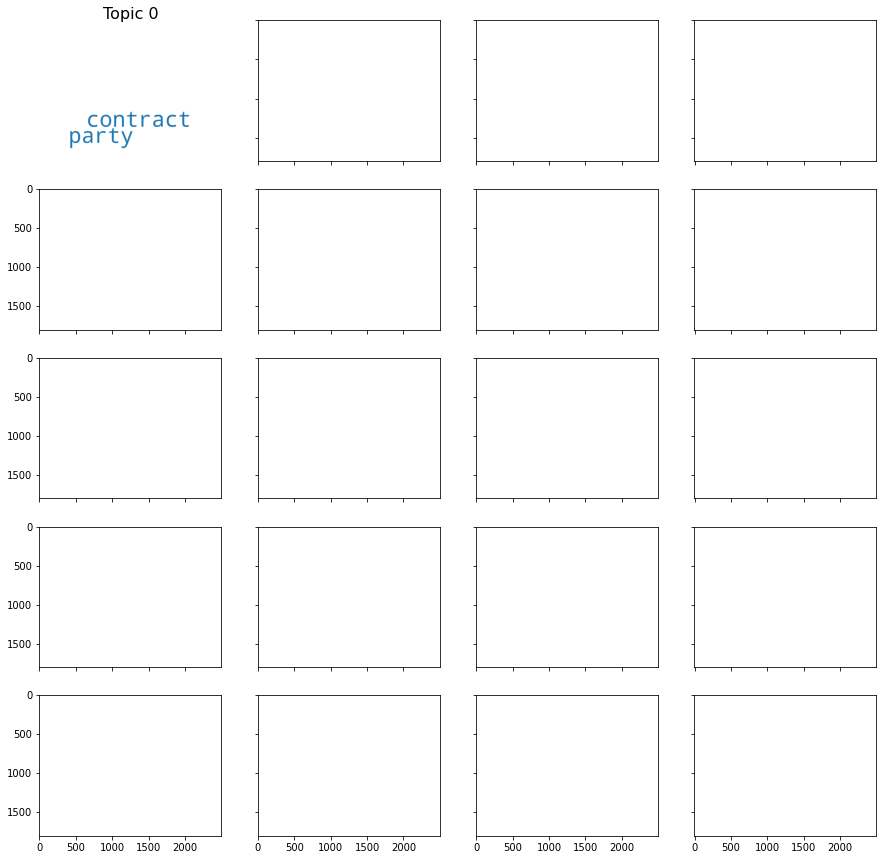

In [45]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols*2
cloud = WordCloud(stopwords=my_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

columns_list = ["Topic "+str(i) for i in range(0,1)]
topics = list()

for i in columns_list:
  topics.append(lsa_result[i].values)

frequencies = list()
columns_list = ["Topic "+str(i)+" weights" for i in range(0,1)]

for i in columns_list:
  frequencies.append(lsa_result[i].values)


fig, axes = plt.subplots(5,4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    size_of_array = len(topics[i])
    topic_words = dict()
    for j in range(size_of_array):
      topic_words[topics[i][j]] = frequencies[i][j]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [2]:

#import AlgorithmHMMLDA as HMMLDA
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
def get_reuters_token_list_by_sentence(num_doc,ip):
    corpus = [[i.split() for i in ip ]]
    print(corpus)
    valid_voca = set(w.lower() for w in nltk.corpus.words.words())
    stop = stopwords.words('english')
    valid_voca = valid_voca.union(stop)

    tmp_corpus = list()
    voca_dic = dict()
    voca = list()
    for doc in corpus:
        tmp_doc = list()
        for sent in doc:
            tmp_sent = list()
            for word in sent:
                if word in valid_voca:
                    tmp_sent.append(word)
                    if word not in voca_dic:
                        voca_dic[word] = len(voca_dic)
                        voca.append(word)
            if len(tmp_sent) > 0:
                tmp_doc.append(tmp_sent)
        if len(tmp_doc) > 0:
            tmp_corpus.append(tmp_doc)

    # convert token list to word index list
    corpus = list()
    for doc in tmp_corpus:
        new_doc = list()
        for sent in doc:
            new_sent = list()
            for word in sent:
                new_sent.append(voca_dic[word])
            new_doc.append(new_sent)
        corpus.append(new_doc)

    return np.array(voca), corpus

In [10]:

n_docs = 1000
voca, corpus = get_reuters_token_list_by_sentence(n_docs,input_df["cleaned_data"].values)

[[['name', 'contract'], ['two', 'parties', 'signed', 'contract'], ['date', 'contract'], ['date', 'contract', 'effective'], ['date', 'contract', 'initial', 'term', 'expire'], ['renewal', 'term', 'initial', 'term', 'expires', 'includes', 'automatic', 'extensions', 'unilateral', 'extensions', 'prior', 'notice'], ['notice', 'period', 'required', 'terminate', 'renewal'], ['state', 'country', 'law', 'governs', 'interpretation', 'contract'], ['clause', 'third', 'party', 'gets', 'better', 'terms', 'licensing', 'sale', 'technology', 'goods', 'services', 'described', 'contract', 'buyer', 'technology', 'goods', 'services', 'contract', 'shall', 'entitled', 'better', 'terms'], ['restriction', 'ability', 'party', 'compete', 'counterparty', 'operate', 'certain', 'geography', 'business', 'technology', 'sector'], ['exclusive', 'dealing', 'commitment', 'counterparty', 'includes', 'commitment', 'procure', 'requirements', 'one', 'party', 'certain', 'technology', 'goods', 'services', 'prohibition', 'licens

Supervised LDA TOPIC MODELLING

In [11]:

!pip install pymc

     |████████████████████████████████| 389kB 11.9MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1352844 sha256=7a34a188ff5473bab0c19110dc7811b62bb06c7e2cb3e2f4322f761177f55975
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


In [12]:
training_data = input_df['cleaned_data'].values

In [13]:
import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from six.moves import xrange
from collections import Counter
nltk.download('words')

def get_ids_cnt(corpus, max_voca=9999999, remove_top_n=5):
    voca = set(w.lower() for w in nltk.corpus.words.words())
    stop = stopwords.words('english')

    docs = list()
    freq = Counter()

    for doc in corpus:
        if isinstance(doc, str):
            doc = word_tokenize(doc)
        elif not hasattr(doc, '__iter__'):
            raise Exception('Corpus is not a list of string or token list')

        # remove word using stopword list or single character word
        doc = [word.lower() for word in doc if word.lower() in voca and word.lower() not in stop and len(word) != 1]
        freq.update(doc)
        docs.append(doc)

    voca = [key for iter, (key, val) in enumerate(freq.most_common(max_voca)) if iter >= remove_top_n]

    voca_dic = dict()
    voca_list = list()
    for word in voca:
        voca_dic[word] = len(voca_dic)
        voca_list.append(word)

    doc_ids = list()
    doc_cnt = list()

    for doc in docs:
        words = set(doc)
        ids = np.array([int(voca_dic[word]) for word in words if word in voca_dic])
        cnt = np.array([int(doc.count(word)) for word in words if word in voca_dic])

        doc_ids.append(ids)
        doc_cnt.append(cnt)

    return np.array(voca_list), doc_ids, doc_cnt


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [14]:

voca, word_ids, word_cnt = get_ids_cnt(training_data)

In [15]:
def convert_cnt_to_list(word_ids, word_cnt):
    corpus = list()

    for di in xrange(len(word_ids)):
        doc = list()
        doc_ids = word_ids[di]
        doc_cnt = word_cnt[di]
        for wi in xrange(len(doc_ids)):
            word_id = doc_ids[wi]
            for si in xrange(doc_cnt[wi]):
                doc.append(word_id)
        corpus.append(doc)
    return corpus

In [16]:
corpus = convert_cnt_to_list(word_ids, word_cnt)

In [18]:
n_doc = len(corpus)
n_voca = voca.size

In [19]:

n_doc

40

In [23]:
import random
#fit artificial sevearity
sevearity = [random.randint(0,1) for i in range(0,40)]

In [24]:
model = SupervisedLDA(n_doc, n_voca, 10, sigma=0.01)
model.fit(corpus, sevearity)

In [25]:
for ti in model.eta.argsort():
    top_words = get_top_words(model.TW, voca, ti, n_words=10)
    print('Eta', model.eta[ti] ,'\nTopic', ti ,':\t', ','.join(top_words))

Eta -3.761053857121863 
Topic 5 :	 enforce,giving,operate,type,maximum,amount,uncapped,compliance,cause,infringement
Eta -1.239549013227431 
Topic 2 :	 commitment,whether,working,include,selling,disparage,category,state,consent,refusal
Eta -0.4588626716463295 
Topic 6 :	 right,notice,first,renewal,assets,initial,market,refusal,unilateral,automatic
Eta -0.17958214734379077 
Topic 7 :	 property,intellectual,upon,ownership,shall,joint,prior,unrelated,become,per
Eta -0.04443173614960434 
Topic 3 :	 termination,fee,contain,prohibition,upon,licensor,wind,name,bankruptcy,subject
Eta -0.006129643879862398 
Topic 9 :	 clause,ability,date,enterprise,would,interpretation,country,exclusive,usage,unlimited
Eta 1.2272629073045058 
Topic 0 :	 grant,requirement,licensee,soliciting,must,therefore,perpetual,insurance,increase,benefit
Eta 1.3896274237340467 
Topic 8 :	 goods,law,restriction,provided,sale,revenue,share,operation,substantially,control
Eta 1.3905837904571139 
Topic 1 :	 breach,obligation,li

In [26]:

!pip install biterm

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for biterm: filename=biterm-0.1.5-cp37-cp37m-linux_x86_64.whl size=195799 sha256=cfdcf34a096c530679de024a65c339674ec7c8cc618883a80fff6b3b5eee2026
  Stored in directory: /root/.cache/pip/wheels/86/04/10/231fb1d39d86ab58c2683fd3d4fe8415a5bc284ba8a20fd638
Successfully built biterm


In [38]:
import sys
sys.path.insert(1,'/content/')
#import AlgorithmBITERM as btm_model
topics = BITERM_MODEL(tf,vectorizer)

NameError: ignored

In [34]:
texts= input_df['cleaned_data'].values
for i in range(len(texts)):
        print("{} (topic: {})".format(texts[i], topics[i].argmax()))


NameError: ignored